# Automated CapsnetsS2I train + test

First, import stuff

In [14]:
import model_s2i
import data_loader
import tensorflow as tf

In [15]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [20]:
WORD_VEC_SCENARIO = "FastText-300-verbsDatasets-synAntVSP-dia"
SCENARIO_NAME = 'vec-fasttext-50'

word2vec_path = '../../romanian_word_vecs/cleaned-vectors-diacritice-cc-50.vec'

# No diacritics data
training_data_paths = [
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
        '../data-capsnets/diacritics/scenario0/train.txt',
        '../data-capsnets/diacritics/scenario1/train.txt',
        '../data-capsnets/diacritics/scenario2/train.txt',
        '../data-capsnets/diacritics/scenario31/train.txt',
        '../data-capsnets/diacritics/scenario32/train.txt',
        '../data-capsnets/diacritics/scenario33/train.txt',
        
    ]
test_data_paths = [
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
    '../data-capsnets/diacritics/scenario0/test.txt',
    '../data-capsnets/diacritics/scenario1/test.txt',
    '../data-capsnets/diacritics/scenario2/test.txt',
    '../data-capsnets/diacritics/scenario31/test.txt',
    '../data-capsnets/diacritics/scenario32/test.txt',
    '../data-capsnets/diacritics/scenario33/test.txt',
]

scenario_nums = [
#     '0_' + WORD_VEC_SCENARIO,
#     '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
#     '0_dia_' + WORD_VEC_SCENARIO,
#     '1_dia_' + WORD_VEC_SCENARIO,
#     '2_dia_' + WORD_VEC_SCENARIO,
#     '31_dia_' + WORD_VEC_SCENARIO,
#     '32_dia_' + WORD_VEC_SCENARIO,
#     '33_dia_' + WORD_VEC_SCENARIO,
    '0-' + SCENARIO_NAME,
    '1-' + SCENARIO_NAME,
    '2-' + SCENARIO_NAME,
    '31-' + SCENARIO_NAME,
    '32-' + SCENARIO_NAME,
    '33-' + SCENARIO_NAME,
]

In [21]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took 000.02
------------------load word2vec end---------------------


# Flag setting functions + utils

In [23]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    tf.app.flags.DEFINE_string('results_dir', './results/', 'Results dir')
    tf.app.flags.DEFINE_string('hyperparams_dir', './hyperparams/', 'Hyperparams dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 16

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 8, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 10, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 3, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    tf.app.flags.DEFINE_float('rerouting_coef', 0.5, 'coefficient for rerouting')
    tf.app.flags.DEFINE_boolean('use_rerouting', True, 'whether to use rerouting or not')
    tf.app.flags.DEFINE_boolean('use_attention', True,
                                'whether to use attention or not. If attention is used,'
                                'slot_output_dim will be overridden to hidden_size * 2')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results/results_{}.csv'.format(SCENARIO_NAME), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [22]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
max length is 15
max length is 15
------------------read datasets end---------------------
TRAINING 0-vec-fasttext-50
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.071429
F score 0.071429
Slot filling
F1 score: 0.009245
Accuracy: 0.039048
------------------epoch :  0  Loss:  29.700327 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.233333
F score 0.233333
Slot filling
F1 score: 0.038339
Accuracy: 0.889206
Current F score mean 0.1358359957401491
Best F score mean 0.1358359957401491
------------------epoch :  1  Loss:  13.39315 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.554762
F score 0.554762
Slot filling
F1 

------------------epoch :  5  Loss:  0.42001018 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.850000
F score 0.850000
Slot filling
F1 score: 0.873469
Accuracy: 0.985714
Current F score mean 0.861734693877551
Best F score mean 0.9841269841269842
------------------epoch :  6  Loss:  0.15947333 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.900000
F score 0.900000
Slot filling
F1 score: 0.919470
Accuracy: 0.988730
Current F score mean 0.9097349643221202
Best F score mean 0.9841269841269842
------------------epoch :  7  Loss:  0.20819113 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.930952
F score 0.930952
Slot filling
F1 score: 0.916667
Accuracy: 0.991587
Current F score mean 0.9238095238095239
Best F score mean 0.9841269841269842
------------------epoch :  8  Loss:  0.17499863 ----------------------
           VALIDAT

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985714
F score 0.985714
Slot filling
F1 score: 0.979592
Accuracy: 0.997778
Current F score mean 0.9826530612244897
Best F score mean 0.9841269841269842
------------------epoch :  12  Loss:  0.040801138 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985714
F score 0.985714
Slot filling
F1 score: 0.982635
Accuracy: 0.997778
Current F score mean 0.9841748139500949
Best F score mean 0.9841748139500949
------------------epoch :  13  Loss:  0.023408452 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.979592
Accuracy: 0.997619
Current F score mean 0.9886054421768706
Best F score mean 0.9886054421768706
------------------epoch :  14  Loss:  0.019370861 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.9

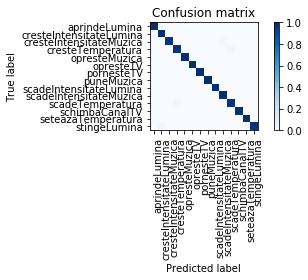

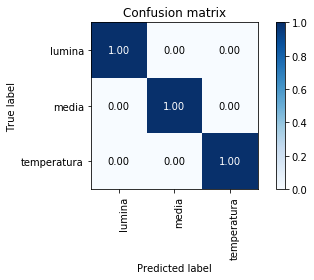

Intent F1: 0.992857
Slot F1: 0.988506
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 1-vec-fasttext-50
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.071429
F score 0.071429
Slot filling
F1 score: 0.015182
Accuracy: 0.132653
------------------epoch :  0  Loss:  27.222988 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.283333
F score 0.283333
Slot filling
F1 score: 0.093398
Accuracy: 0.886395
Current F score mean 0.18836553945249596
Best F score mean 0.18836553945249596
------------------epoch :  1  Loss:  11.475618 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0

------------------epoch :  5  Loss:  0.46403962 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.909524
F score 0.909524
Slot filling
F1 score: 0.907298
Accuracy: 0.992177
Current F score mean 0.9084108199492815
Best F score mean 0.9830181359712928
------------------epoch :  6  Loss:  0.2562687 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.909524
F score 0.909524
Slot filling
F1 score: 0.947159
Accuracy: 0.995748
Current F score mean 0.9283411669752647
Best F score mean 0.9830181359712928
------------------epoch :  7  Loss:  0.15183818 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.971429
F score 0.971429
Slot filling
F1 score: 0.960961
Accuracy: 0.996599
Current F score mean 0.9661947661947662
Best F score mean 0.9830181359712928
------------------epoch :  8  Loss:  0.13146538 ----------------------
           VALIDAT

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.982000
Accuracy: 0.998129
Current F score mean 0.991
Best F score mean 0.9929577464788732
------------------epoch :  12  Loss:  0.014574641 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.983017
Accuracy: 0.998299
Current F score mean 0.9915084915084915
Best F score mean 0.9929577464788732
------------------epoch :  13  Loss:  0.011312169 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.997619
F score 0.997619
Slot filling
F1 score: 0.983017
Accuracy: 0.998299
Current F score mean 0.9903180153180153
Best F score mean 0.9929577464788732
------------------epoch :  14  Loss:  0.011396741 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score

<Figure size 432x288 with 0 Axes>

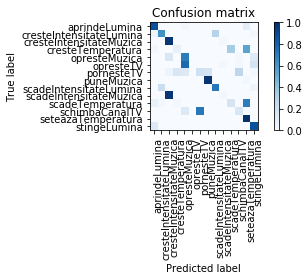

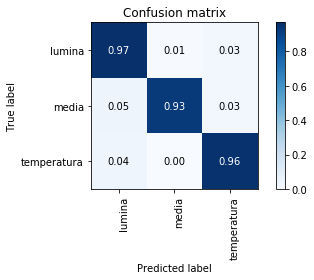

Intent F1: 0.526786
Slot F1: 0.777305
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 2-vec-fasttext-50
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.075000
F score 0.075000
Slot filling
F1 score: 0.017771
Accuracy: 0.053571
------------------epoch :  0  Loss:  29.89896 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.402778
F score 0.402778
Slot filling
F1 score: 0.047794
Accuracy: 0.871825
Current F score mean 0.2252859477124183
Best F score mean 0.2252859477124183
------------------epoch :  1  Loss:  12.953226 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.60

------------------epoch :  5  Loss:  0.85965157 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.927778
F score 0.927778
Slot filling
F1 score: 0.937630
Accuracy: 0.990079
Current F score mean 0.9327038577038578
Best F score mean 0.994582306699519
------------------epoch :  6  Loss:  0.415916 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.958333
F score 0.958333
Slot filling
F1 score: 0.962733
Accuracy: 0.995040
Current F score mean 0.9605331262939959
Best F score mean 0.994582306699519
------------------epoch :  7  Loss:  0.21254006 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.963889
F score 0.963889
Slot filling
F1 score: 0.975207
Accuracy: 0.997619
Current F score mean 0.9695477502295684
Best F score mean 0.994582306699519
------------------epoch :  8  Loss:  0.16177778 ----------------------
           VALIDATION 

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.983333
F score 0.983333
Slot filling
F1 score: 0.985801
Accuracy: 0.998810
Current F score mean 0.9845672751859365
Best F score mean 0.994582306699519
------------------epoch :  12  Loss:  0.027146338 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.986111
F score 0.986111
Slot filling
F1 score: 0.988832
Accuracy: 0.999008
Current F score mean 0.9874717992103779
Best F score mean 0.994582306699519
------------------epoch :  13  Loss:  0.022057306 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.983333
F score 0.983333
Slot filling
F1 score: 0.988832
Accuracy: 0.999008
Current F score mean 0.986082910321489
Best F score mean 0.994582306699519
------------------epoch :  14  Loss:  0.018652596 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.98611

<Figure size 432x288 with 0 Axes>

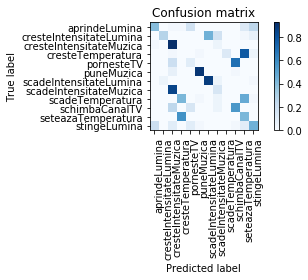

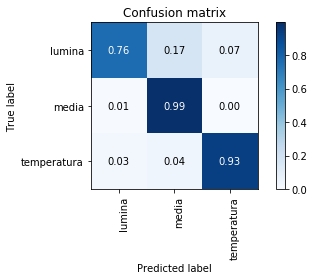

Intent F1: 0.420833
Slot F1: 0.602740
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 31-vec-fasttext-50
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.096154
F score 0.096154
Slot filling
F1 score: 0.012476
Accuracy: 0.089286
------------------epoch :  0  Loss:  31.022564 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.358974
F score 0.358974
Slot filling
F1 score: 0.023148
Accuracy: 0.893086
Current F score mean 0.19106125356125356
Best F score mean 0.19106125356125356
------------------epoch :  1  Loss:  15.512772 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 

------------------epoch :  5  Loss:  0.711915 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.923077
F score 0.923077
Slot filling
F1 score: 0.915663
Accuracy: 0.991071
Current F score mean 0.9193697868396664
Best F score mean 0.975503663003663
------------------epoch :  6  Loss:  0.28928193 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.932692
F score 0.932692
Slot filling
F1 score: 0.919473
Accuracy: 0.985577
Current F score mean 0.926082610654353
Best F score mean 0.975503663003663
------------------epoch :  7  Loss:  0.19120204 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.967949
F score 0.967949
Slot filling
F1 score: 0.963746
Accuracy: 0.996566
Current F score mean 0.9658474707568363
Best F score mean 0.975503663003663
------------------epoch :  8  Loss:  0.11270843 ----------------------
           VALIDATION S

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.980769
F score 0.980769
Slot filling
F1 score: 0.959641
Accuracy: 0.995879
Current F score mean 0.970205243187306
Best F score mean 0.9835767485162341
------------------epoch :  12  Loss:  0.027998637 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.983974
F score 0.983974
Slot filling
F1 score: 0.958209
Accuracy: 0.996108
Current F score mean 0.9710916570991198
Best F score mean 0.9835767485162341
------------------epoch :  13  Loss:  0.024668163 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.983974
F score 0.983974
Slot filling
F1 score: 0.959762
Accuracy: 0.996337
Current F score mean 0.9718679544499216
Best F score mean 0.9835767485162341
------------------epoch :  14  Loss:  0.021186927 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.98

<Figure size 432x288 with 0 Axes>

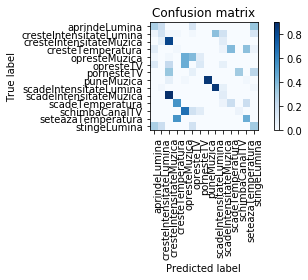

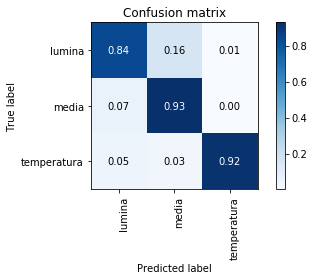

Intent F1: 0.332143
Slot F1: 0.547697
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 32-vec-fasttext-50
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.088496
F score 0.088496
Slot filling
F1 score: 0.024585
Accuracy: 0.153603
------------------epoch :  0  Loss:  26.99355 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.271386
F score 0.271386
Slot filling
F1 score: 0.190024
Accuracy: 0.931521
Current F score mean 0.23070509182379362
Best F score mean 0.23070509182379362
------------------epoch :  1  Loss:  14.186726 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0

------------------epoch :  5  Loss:  1.8080086 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.873156
F score 0.873156
Slot filling
F1 score: 0.937107
Accuracy: 0.992204
Current F score mean 0.9051316302109422
Best F score mean 0.9696689609963947
------------------epoch :  6  Loss:  0.2493186 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.870206
F score 0.870206
Slot filling
F1 score: 0.946875
Accuracy: 0.992836
Current F score mean 0.908540744837758
Best F score mean 0.9696689609963947
------------------epoch :  7  Loss:  0.23098513 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.920354
F score 0.920354
Slot filling
F1 score: 0.951334
Accuracy: 0.994943
Current F score mean 0.9358441811033467
Best F score mean 0.9696689609963947
------------------epoch :  8  Loss:  0.07011137 ----------------------
           VALIDATIO

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.982301
F score 0.982301
Slot filling
F1 score: 0.951952
Accuracy: 0.994732
Current F score mean 0.967126418453852
Best F score mean 0.971906938405042
------------------epoch :  12  Loss:  0.3241381 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.982301
F score 0.982301
Slot filling
F1 score: 0.946108
Accuracy: 0.993679
Current F score mean 0.964204334693445
Best F score mean 0.971906938405042
------------------epoch :  13  Loss:  0.19706419 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.982301
F score 0.982301
Slot filling
F1 score: 0.943284
Accuracy: 0.993468
Current F score mean 0.9627922335226522
Best F score mean 0.971906938405042
------------------epoch :  14  Loss:  0.13654895 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985251
F s

<Figure size 432x288 with 0 Axes>

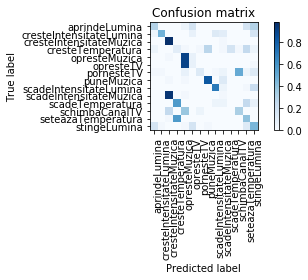

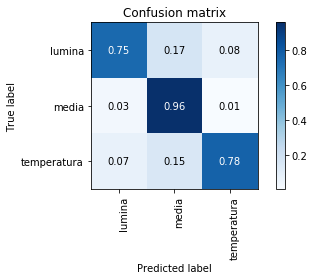

Intent F1: 0.405357
Slot F1: 0.434909
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 33-vec-fasttext-50
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.012987
F score 0.012987
Slot filling
F1 score: 0.025572
Accuracy: 0.094620
------------------epoch :  0  Loss:  34.406876 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.333333
F score 0.333333
Slot filling
F1 score: 0.079208
Accuracy: 0.841682
Current F score mean 0.20627062706270627
Best F score mean 0.20627062706270627
------------------epoch :  1  Loss:  23.656063 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 

------------------epoch :  5  Loss:  4.4231334 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.883117
F score 0.883117
Slot filling
F1 score: 0.873973
Accuracy: 0.979901
Current F score mean 0.8785447429283045
Best F score mean 0.9755600386668348
------------------epoch :  6  Loss:  2.3976216 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.913420
F score 0.913420
Slot filling
F1 score: 0.923288
Accuracy: 0.988868
Current F score mean 0.9183537923263951
Best F score mean 0.9755600386668348
------------------epoch :  7  Loss:  1.4010179 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.935065
F score 0.935065
Slot filling
F1 score: 0.941015
Accuracy: 0.991651
Current F score mean 0.9380400121140862
Best F score mean 0.9755600386668348
------------------epoch :  8  Loss:  0.64022595 ----------------------
           VALIDATIO

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.930736
F score 0.930736
Slot filling
F1 score: 0.984701
Accuracy: 0.997835
Current F score mean 0.9577184521551698
Best F score mean 0.9866806775520469
------------------epoch :  12  Loss:  0.23118976 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.939394
F score 0.939394
Slot filling
F1 score: 0.977778
Accuracy: 0.997217
Current F score mean 0.9585858585858587
Best F score mean 0.9866806775520469
------------------epoch :  13  Loss:  0.22585896 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.948052
F score 0.948052
Slot filling
F1 score: 0.981969
Accuracy: 0.997526
Current F score mean 0.9650107174379019
Best F score mean 0.9866806775520469
------------------epoch :  14  Loss:  0.14439058 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.9567

<Figure size 432x288 with 0 Axes>

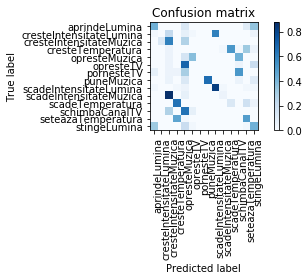

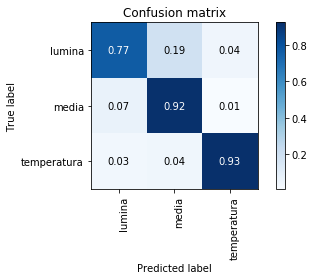

Intent F1: 0.268336
Slot F1: 0.528523


<Figure size 432x288 with 0 Axes>

In [24]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    isLowercase = False # When using the new 100-dim word vec model (conll, not fasttext), the data should all be in lowercase
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True, lowercase=isLowercase)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(model_s2i.CapsNetS2I, data, FLAGS, batches_rand=False)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(model_s2i.CapsNetS2I, data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)